In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Problem 1

Note: I made a class to do all the calculations for this problem, then I loop through the events to plot and print the results in the cells below. You can set the directory at the top of the next cell. The .npz files come from the output of "simple_read_ligo.py", these contain the data needed to run this notebook.

(a) *Come up with a noise model for the Livingston and Hanford detectors separately and describe how. Mention how you smooth the power spectrum and how you deal with lines. Explain how you window the data (might want a window that has an extended flat period near the center to avoid tapering the data/template where the signal is not small.*

Assume stationary noise, so we want to divide the Fourier transform of the strain by its smoothed power spectrum, then Fourier transform back. So this means $N^{-1}$ is the inverted power spectrum. I used one of Jon's functions to smooth the power spectrum (convolving with a Gaussian kernel in 1 dimension) and did some trial and error to find a $\sigma$. I also set $N^{-1}$ to be zero from frequencies outside 20 to 2000 Hz (the LIGO tutorial specifies that below 20 Hz the data isn't properly calibrated and 2000 Hz is just below the Nyquist frequency which gives the upper limit on detectable frequencies for these events).

I found that using a Blackman-Harris taper for one detector and a Tukey window for the other gave the most prominent spikes in the results of the matched filter, plus these choices didn't spread out the power too much and flattened some of the spikes.

(b) *Use this noise model to search the four sets of events using a matched filter. The mapping between data and templates can be found in "BBH_events_v2.json".*

The matched filter result comes from the right hand side of the linear least squares equation: $\text{RHS} = A^T N^{-1} d$. In this case, $\text{RHS}$ comes from taking the inverse Fourier transform of the noise-filtered template convolved with the data. (They're both windowed with a cosine function to take the Fourier transform). The noise-filtering is done by dividing the template by the noise model described above.

(c) *Estimate a noise for each event, and from the output of the matched filter, give a signal-to-noise ratio (SNR) for each event, both from the individual detectors and from the combined Livingston + Hanford events.*

The SNR is the absolute value of the result of the matched filter divided by $\sqrt{\text{LHS}}$, where $\text{LHS}$ is the sum of the convolution of the noise-filtered template signal with the template signal (both in Fourier space). 

(Note - I realized while doing my final edits that I did not do the combined Livingston + Hanford SNRs).

(d) *Compare the SNR you get from the scatter in the matched filter to the analytic SNR you expect from your noise model. How close are they, and if they disagree explain why.*

The analytical SNR is the height of the spike in the SNR described above. The SNR derived from scatter is the standard deviation of the matched filter result ($\text{RHS}$).

(e) *From the template and noise model, find the frequency from each event where half the weight comes from above that frequency and half below.*

I think this means to take the whitened template's power spectrum and integrate it along the frequencies. Then find the frequency where the integral is split in half.

(f) *How well can you localize the time of arrival (horizontal shift of the matched filter). The positions of gravitational wave events are inferred by comparing their arrival times at different detectors. What is the typical positional uncertainty you might expect given that the detectors are a few thousand km apart?*

(Note - this part is not done).

In [11]:
# set the directory here
directory='./'

# Jon's function for smoothing the power spectrum
def smooth_vector(vec,sig):
    n=len(vec)
    x=np.arange(n)
    x[n//2:]=x[n//2:]-n
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()
    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    return vec_smooth

# Class for doing all Problem 1 parts
class mf_ligo:
    
    def __init__(self, data_num, dat_path=directory):

        # Name the files and GW events
        if data_num == 1:
            fname_L = 'L-L1_LOSC_4_V2-1126259446-32.npz'
            fname_H = 'H-H1_LOSC_4_V2-1126259446-32.npz'
            fname_t = 'GW150914_4_template.npz'
            self.gw_name = "GW150914"
        elif data_num == 2:
            fname_L = 'L-L1_LOSC_4_V2-1128678884-32.npz'
            fname_H = 'H-H1_LOSC_4_V2-1128678884-32.npz'
            fname_t = 'LVT151012_4_template.npz'
            self.gw_name = "LVT151012"
        elif data_num == 3:
            fname_L = 'L-L1_LOSC_4_V2-1135136334-32.npz'
            fname_H = 'H-H1_LOSC_4_V2-1135136334-32.npz'
            fname_t = 'GW151226_4_template.npz'
            self.gw_name = "GW151226"
        elif data_num == 4:
            fname_L = 'L-L1_LOSC_4_V1-1167559920-32.npz'
            fname_H = 'H-H1_LOSC_4_V1-1167559920-32.npz'
            fname_t = 'GW170104_4_template.npz'
            self.gw_name = "GW170104"

        # Data names given by detectors
        self.data_names = ['Livingston', 'Hanford']

        # All the arrays and values I want to save
        self.strains, self.tp, self.time, self.nu, self.nu0 = [],[],[],[],[]
        self.strain_pspec, self.win_pspec, self.smooth_pspec = [],[],[]
        self.RHS, self.SNR, self.SNR_analytical, self.SNR_scatter, self.half_nus = [],[],[],[],[]

        for datas in ['Livingston', 'Hanford']:

            if datas=='Livingston':
                dat = np.load(dat_path+fname_L, allow_pickle=True)
                strain = dat['strain']
                win = np.blackman(len(strain))
                # Windows that did not look good:
                #win = np.cos(np.linspace(-np.pi/2, np.pi/2, len(strain)))
                #win = signal.tukey(len(strain), alpha=1.0/8) # amps were super small from this one
            elif datas=='Hanford':
                dat = np.load(dat_path+fname_H, allow_pickle=True)
                strain = dat['strain']
                # Windows that did not look good:
                #win = np.blackman(len(strain)) # amps were super small from this one
                #win = np.cos(np.linspace(-np.pi/2, np.pi/2, len(strain)))
                # try scipy tukey?
                win = signal.tukey(len(strain), alpha=1.0/8)

            # Append the raw data
            self.strains.append(strain)

            # Load template
            gw_dat = np.load(dat_path+fname_t, allow_pickle=True)
            self.tp, tx = gw_dat['tp'], gw_dat['tx']

            # Get the times and total observation time
            dt = dat['dt']
            time = dt*np.arange(len(strain))
            self.time.append(time)
            utc = dat['utc']
            t_tot = dt*len(strain)
            
            # Save the power spectrum (un-windowed, un-smoothed)
            strain_ft_raw = np.fft.fft(strain)
            self.strain_pspec.append(np.abs(strain_ft_raw)**2)
            
            # Make frequencies for the raw fft
            nu0 = np.arange(len(strain_ft_raw))/t_tot
            self.nu0.append(nu0)

            # FFT the windowed strain
            strain_ft = np.fft.fft(win*strain)

            # Save the windowed power specrtum
            self.win_pspec.append(np.abs(strain_ft)**2)
        
            # Trial and error to find a nice sigma to smooth
            strain_smooth = smooth_vector(np.abs(strain_ft)**2,sig=10)
            strain_smooth = strain_smooth[:len(strain_ft)//2+1]

            # Save the smoothed power spectrum
            self.smooth_pspec.append(strain_smooth)
            
            # Make Ninv using the smoothed spectrum
            Ninv = 1/strain_smooth

            # Make the frequencies: k=i corresponds to nu=i/(total observation time)
            nu = np.arange(len(strain_smooth))/t_tot
            self.nu.append(nu)

            # Zero the frequencies we don't care about (>20 Hz, <2000 Hz)
            Ninv[nu<20] = 0
            Ninv[nu>2000] = 0

            # Whiten the model/template by the noise
            # I'm not sure, but do I need a new window? (blackman gave a infinite SNRs...)
            win = np.cos(np.linspace(-np.pi/2, np.pi/2, len(self.tp)))
            
            # Normalization for window and Fourier transforms
            win_norm = 1/np.sqrt(np.mean(win**2))
            ft_norm = 1/np.sqrt(len(self.tp))
            
            # Fourier transform the windowed template and filter it
            template_ft = np.fft.rfft(self.tp*win) *win_norm*ft_norm # normed now
            template_filt = template_ft*Ninv 
            
            # Fourier tranform windowed data
            data_ft = np.fft.rfft(strain*win) *win_norm*ft_norm # normed now

            # Get inverse Fourier transform normalization
            ift_norm = len(data_ft)
            
            # Matched filter is the convolution
            rhs = np.fft.irfft(data_ft*np.conj(template_filt)) *ift_norm # normed now
            self.RHS.append(rhs)

            # Get the SNR (analytical)
            scale_SNR = np.sum(template_ft*np.conj(template_filt))
            SNR = np.abs(rhs)/np.sqrt(np.abs(scale_SNR))
            self.SNR.append(SNR)
            self.SNR_analytical.append(np.max(SNR))
            
            # Get the SNR (from the scatter)
            SNR_scatter = np.std(rhs)
            self.SNR_scatter.append(SNR_scatter)

            # Find the frequency where half the weight is above and half below.
            # I'm repeating the above process, but using whitening - meaning
            # taking the square root of N^-1

            # Whiten the template
            ninv = np.sqrt(Ninv)
            template_ft = np.fft.rfft(self.tp*win) *win_norm*ft_norm # normed now
            template_wh = template_ft*ninv

            # Integrate along frequencies
            template_pspec = np.abs(template_wh)**2
            integral=np.cumsum(template_pspec*(nu[1]-nu[0]))

            # Halve the weight
            half_weight = integral[-1]/2

            # Find frequency where this happens
            mask_weight = integral <= half_weight
            half_nu = nu[mask_weight][-1]
            self.half_nus.append(half_nu)

Initialize the class for each event.

In [12]:
LIGO = []

for i in range(4):
    
    # get the ligo object
    ligo_i = mf_ligo(data_num=i+1)
    
    # append it
    LIGO.append(ligo_i)

Plot the data, raw strain power spectrum, windowed power spectrum, and smoothed power spectrum (for each event).

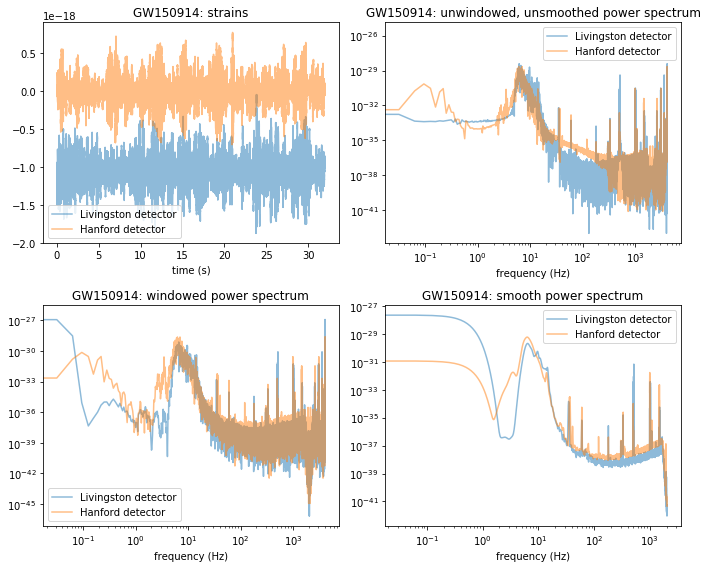

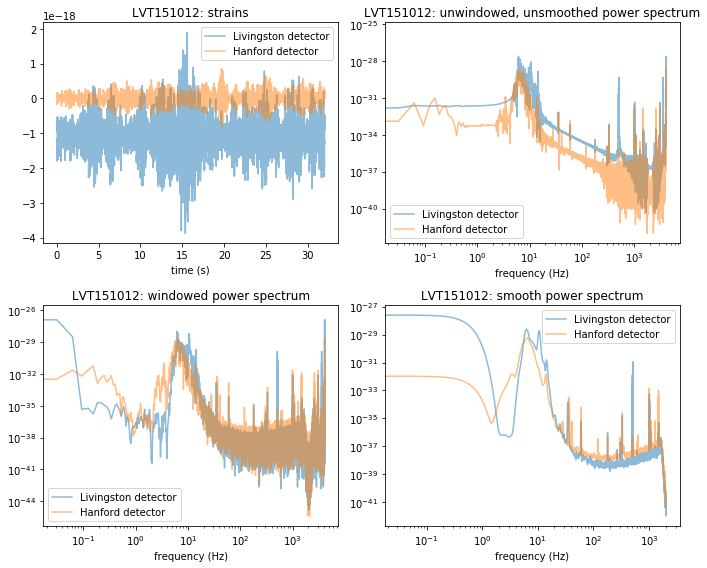

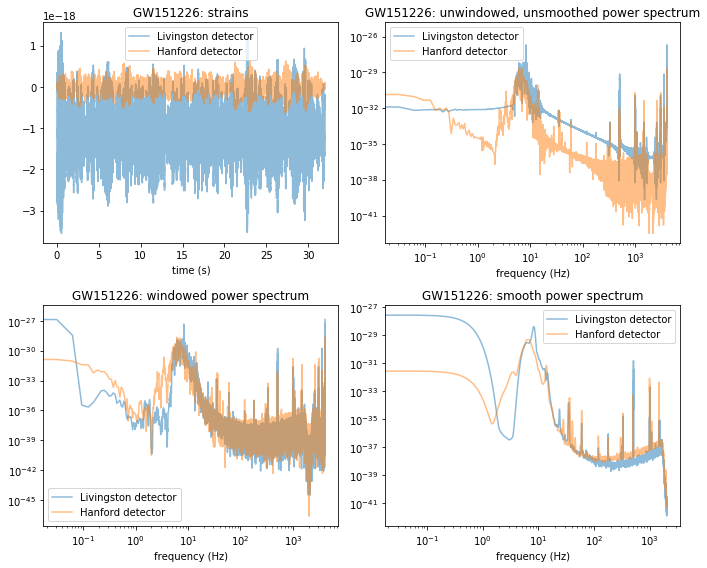

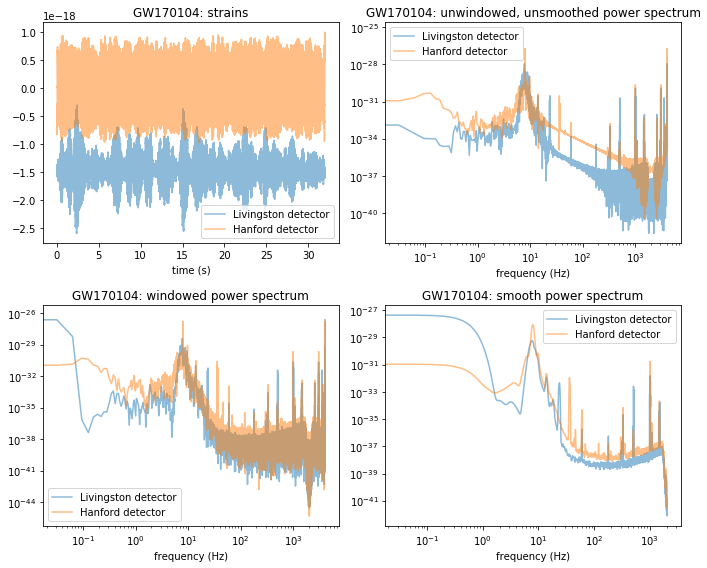

In [13]:
# 4 plots for each event
for i in range(4):
    
    # get the relevant things to plot
    ligo = LIGO[i]
    gw_name = ligo.gw_name
    strains = ligo.strains
    time = ligo.time
    nu = ligo.nu
    nu0 = ligo.nu0
    strain_pspec = ligo.strain_pspec
    win_pspec = ligo.win_pspec
    smooth_pspec = ligo.smooth_pspec
    data_names = ligo.data_names
    
    # put into arrays to loop through spectra
    specs_arr = [strains, strain_pspec, win_pspec, smooth_pspec]
    specs_labels = ['strains', 'unwindowed, unsmoothed power spectrum', 
                   'windowed power spectrum', 'smooth power spectrum']
    x_arr = [time, nu0, nu0, nu]
    x_labels = ['time (s)', 'frequency (Hz)', 'frequency (Hz)', 'frequency (Hz)']
    det_names = 4*[data_names]

    # 4 plots for each type of spectrum
    fig, axs = plt.subplots(2,2,figsize=(10,8),tight_layout=True)
    axs = axs.ravel()
    for j in range(4):
        
        # plot for both detectors
        if j==0:
            axs[j].plot(x_arr[j][0], specs_arr[j][0], alpha=0.5, label='{} detector'.format(det_names[j][0]))
            axs[j].plot(x_arr[j][1], specs_arr[j][1], alpha=0.5, label='{} detector'.format(det_names[j][1]))
        else: 
            axs[j].loglog(x_arr[j][0], specs_arr[j][0], alpha=0.5, label='{} detector'.format(det_names[j][0]))
            axs[j].loglog(x_arr[j][1], specs_arr[j][1], alpha=0.5, label='{} detector'.format(det_names[j][1]))
        axs[j].set_xlabel(x_labels[j])
        axs[j].set_title('{}: {}'.format(gw_name, specs_labels[j]))
        axs[j].legend()

Plot the matched filter results:

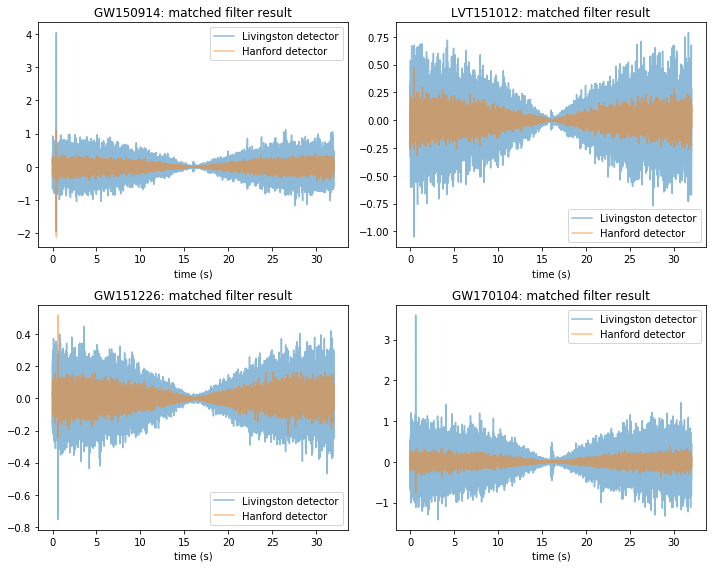

In [14]:
fig, axs = plt.subplots(2,2,figsize=(10,8),tight_layout=True)
axs = axs.ravel()

# 4 plots for each event
for i in range(4):
    
    # get the relevant things to plot
    ligo = LIGO[i]
    gw_name = ligo.gw_name
    time = ligo.time
    data_names = ligo.data_names
    rhs = ligo.RHS
    
    # plot both detectors
    axs[i].plot(time[0], rhs[0], alpha=0.5, label='{} detector'.format(data_names[0]))
    axs[i].plot(time[1], rhs[1], alpha=0.5, label='{} detector'.format(data_names[1]))
    axs[i].set_xlabel('time (s)')
    axs[i].set_title('{}: matched filter result'.format(gw_name))
    axs[i].legend()

Fig: Both the detectors for LVT151012 are giving the worst result of the four events (good results being a very statistically significant spike indicating where in time the matched filter thinks the template can be found in the data).

Plot the SNR results and print one number for each:

Event: GW150914
Livingston SNR from scatter = 0.2309 and analytical = 0.0616
Hanford SNR from scatter = 0.085 and analytical = 0.0499
Event: LVT151012
Livingston SNR from scatter = 0.156 and analytical = 0.0234
Hanford SNR from scatter = 0.0548 and analytical = 0.0171
Event: GW151226
Livingston SNR from scatter = 0.0834 and analytical = 0.0315
Hanford SNR from scatter = 0.0374 and analytical = 0.0274
Event: GW170104
Livingston SNR from scatter = 0.28 and analytical = 0.0453
Hanford SNR from scatter = 0.0679 and analytical = 0.0221


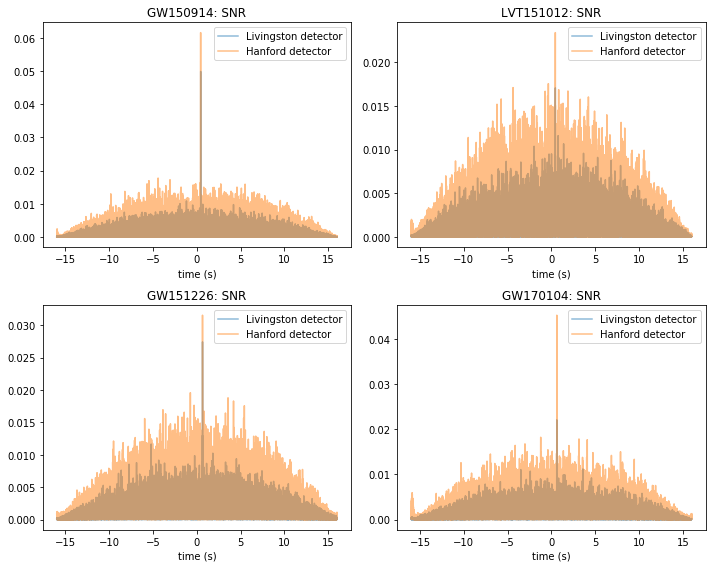

In [18]:
fig, axs = plt.subplots(2,2,figsize=(10,8),tight_layout=True)
axs = axs.ravel()

# 4 plots for each event
for i in range(4):
    
    # get the relevant things to plot
    ligo = LIGO[i]
    gw_name = ligo.gw_name
    time = ligo.time
    data_names = ligo.data_names
    SNR = ligo.SNR
    SNR_analytical = ligo.SNR_analytical
    SNR_scatter = ligo.SNR_scatter
    
    # shift the SNR
    SNR = np.fft.fftshift(SNR)
    
    # print SNR for both detectors
    print('Event: {}'.format(gw_name))
    print('{} SNR from scatter = {} and analytical = {}'.format(data_names[0], 
                                                                np.around(SNR_scatter[0],4), 
                                                                np.around(SNR_analytical[0],4)))
    print('{} SNR from scatter = {} and analytical = {}'.format(data_names[1], 
                                                                np.around(SNR_scatter[1],4), 
                                                                np.around(SNR_analytical[1],4)))
    
    # plot both detectors
    axs[i].plot(time[0] - time[0][-1]/2, SNR[0], alpha=0.5, label='{} detector'.format(data_names[0]))
    axs[i].plot(time[1] - time[1][-1]/2, SNR[1], alpha=0.5, label='{} detector'.format(data_names[1]))
    axs[i].set_xlabel('time (s)')
    axs[i].set_title('{}: SNR'.format(gw_name))
    axs[i].legend()

Fig: Comparing the y axes of this against the LIGO tutorial, I know there's a mistake in calculating the SNRs.

SNR comments: I would guess that my analytical and scatter-derived SNRs are off for a couple reasons. For one, I could have my normalizations wrong: I had to normalize because of the window function, which is used on both the template and the data, and the Fourier plus inverse Fourier transforms, so there are many oportunities to get that wrong. Secondly, I think the analytic SNRs would match the scatter if we could say with certainty that we trust the noise model, which here could have coding errors as well as assumptions about the noise being stationary.

Print the frequencies where half the weight is above and half below:

In [16]:
# loop through evens
for i in range(4):
    
    # load the frequencies
    ligo = LIGO[i]
    gw_name = ligo.gw_name
    data_names = ligo.data_names
    half_nu = ligo.half_nus

    # print the results for both detectors
    print('event: {}'.format(gw_name))
    print('{} detector: half weight at frequency {}'.format(data_names[0], half_nu[0]))
    print('{} detector: half weight at frequency {}'.format(data_names[1], half_nu[1]))

event: GW150914
Livingston detector: half weight at frequency 117.28125
Hanford detector: half weight at frequency 105.09375
event: LVT151012
Livingston detector: half weight at frequency 98.3125
Hanford detector: half weight at frequency 81.6875
event: GW151226
Livingston detector: half weight at frequency 108.1875
Hanford detector: half weight at frequency 80.34375
event: GW170104
Livingston detector: half weight at frequency 76.09375
Hanford detector: half weight at frequency 98.0


Should these agree with each other more?

For the final question, I wasn't able to complete it in time. I think the idea was to take the difference between SNR peaks for the two events to get the time difference. Then convert that to spatial distance using the speed of light. I have to think longer about how to get the positional uncertainty for detectors that are separated by a few thousand km.

# Problem 2

*Assume we have a circular dish that is illuminated by a feed with a Gaussian beam pattern. For simplicity, you may assume everything is plane-parallel, the Gaussian can go to infinity, etc. You can pick the $\sigma$ of the feed's beam relative to the dish radius.* **What value maximizes the signal at the feed?** *You'll have the usual $A_{eff}$ gain but will need to scale that by the fraction of the feed beam that ends up on the primary. If the feed beam is too large then most of it ends up missing the primary, too small then most of the primary isn't getting used and $A_{eff}$ is very small.*

*Plot the signal strength at the feed against $\sigma$ (in units where the dish radius is 1). What is $A_{eff}/A$ at the peak? What fraction of the feed beam ends up off the primary? Might want to compare the contribution to $T_{sys}$ from that part of the beam assuming it ends up on the ground ($T \approx 300K$) relative to the noise temperature of a good cryogenic receiver ($T_{feed} \approx 20-25K$).*

Disclaimer: I am very lost for this question!

We have a Gaussian beam pattern with a circular aperture: $exp(-\frac{k^2}{2\sigma^2})$. The electric field intensity is then $|FT(\text{aperture})| = |FT(exp(-\frac{k^2}{2\sigma^2}))|$ and the power is $|FT(exp(-\frac{k^2}{2\sigma^2}))|^2$. Since the Fourier transform of a Gaussian is a Gaussian, this means the signal strength (power) is a Gaussian squared.

In the notes, it says the circular aperture works out to be $I_0 \frac{4J_1^2(x)}{x^2}$ where $x=kasin(\theta)$, $k=\frac{2 \pi}{\lambda}$, $a=\text{dish radius}$. Is this the beam pattern? And should we then use the (real space) Gaussian as $J_1(x)$? Then use the diffraction limit so $ \theta = \frac{\lambda}{d} = 2 \lambda $ because $d=a/2$ where $a=1$ for this problem?

If yes, this means $x = \frac{2 \pi}{\lambda} (2 \lambda) = 4 \pi$, and the beam pattern is proportional to $exp(-\frac{x^2}{\sigma^2})$.

For the following questions, we know that the power is flux times $A_{eff}$, and that the collecting area ($A$) times the beam area (the Gaussian) is constant. That's all I have.

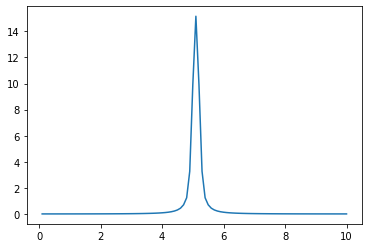

In [17]:
# sigma values
sigmas = np.linspace(0.1,10,100)

# x = 4 pi
x = 4*np.pi

# Gaussian beam
gauss = np.exp(-x**2/sigmas**2)

# signal strength
power = np.abs(np.fft.fft(gauss))**2

# plot
plt.figure()
plt.plot(sigmas, np.fft.fftshift(power))

Fig: The power peaks at the center sigma value. I know this plot has to be wrong, I'm just lost as to how to relate the Gaussian beam pattern to power.

# Not for grading:

This is a white-noise-in-white-noise-out sanity check for the LIGO problem, no need to read it.

real variance =  0.25005197033172155
fourier variance =  0.2525987121751603
(4.076993851335606e-29+6.874910661876256e-47j)
rhs var (real) =  3.297699955909634e-33
0.000244140625 131072


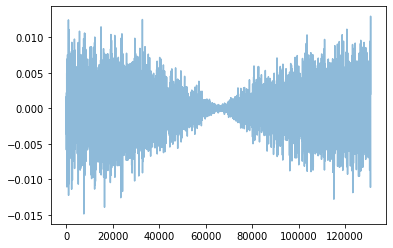

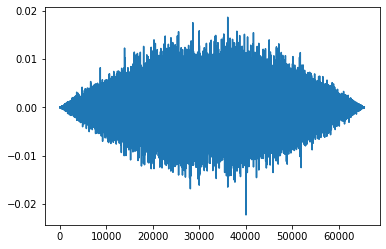

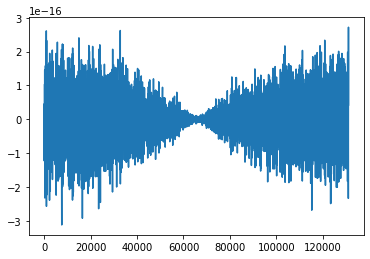

In [325]:
# white noise test, printing variances?

for datas in ['wh']:
    
    
    # load data
    if datas=='L':
        dat = np.load('L-L1_LOSC_4_V2-1126259446-32.npz', allow_pickle=True)
        strain = dat['strain']
        win = np.blackman(len(strain))
        
    elif datas=='H':
        dat = np.load('H-H1_LOSC_4_V2-1126259446-32.npz', allow_pickle=True)
        strain = dat['strain']
        #win = np.hamming(len(strain))
        #win = np.blackman(len(strain))
        win = np.cos(np.linspace(-np.pi/2, np.pi/2, len(strain)))
    
    elif datas=='wh':
        strain = np.random.normal(0,0.5,len(strain))
        win = np.blackman(len(strain))
        # variance of strain:
        var_real = np.mean(strain**2)
        print('real variance = ', var_real)
        
    # load template
    # load template
    gw_dat = np.load('GW150914_4_template.npz', allow_pickle=True)
    tp, tx = gw_dat['tp'], gw_dat['tx']

    # load data and get the total observation time
    #L_dat = np.load('H-H1_LOSC_4_V2-1126259446-32.npz', allow_pickle=True) #np.load('L-L1_LOSC_4_V2-1126259446-32.npz', allow_pickle=True)
    #strain = dat['strain']
    dt = dat['dt']
    utc = dat['utc']
    t_tot = dt*len(strain)

    # make the window function
    #win = np.hamming(len(strain))
    #win = np.blackman(len(strain))
    #win = np.cos(np.linspace(-np.pi/2, np.pi/2, len(strain)))

    # FFT the windowed strain
    strain_ft = np.fft.fft(win*strain)
    # norm...
    win_norm = 1/np.sqrt(np.mean(win**2))
    ft_norm = 1/np.sqrt(len(strain))
    ift_norm = len(strain) # not sure...
    # now apply to strain:
    strain_ft = strain_ft *ft_norm*win_norm
    var_ft = np.real(np.mean(strain_ft*np.conj(strain_ft)))
    print('fourier variance = ', var_ft)

    # plot and inspect the unsmoothed power spectrum 
    #plt.figure()
    #plt.loglog(np.abs(strain_ft**2))

    # restrict to nu < 20 Hz and nu < 2000 Hz
    #plt.xlim(20,2000)

    # maybe delete this????
    # find k-limits: nu_min=20 to nu_max=2000
    # k_mask = nu <= 20
    # k_min = k[k_mask][-1]
    # k_mask = nu >= 2000
    # k_max = k[k_mask][0]

    

    # trial and error to find a nice sigma
    strain_smooth = smooth_vector(np.abs(strain_ft)**2,sig=10)
    strain_smooth = strain_smooth[:len(strain_ft)//2+1]

    # make Ninv using the smoothed spectrum
    Ninv = 1/strain_smooth

    # make the frequencies: k=i corresponds to nu=i/(total observation time)
    nu = np.arange(len(strain_smooth))/t_tot

    # zero the frequencies we don't care about (>20 Hz, <2000 Hz)
    Ninv[nu<20] = 0
    Ninv[nu>1800] = 0

    # whiten the model/template by the noise
    # OK not sure, but do I need a new window?
    win = np.cos(np.linspace(-np.pi/2, np.pi/2, len(tp)))
    template_ft = np.fft.rfft(tp*win)
    template_filt = template_ft*Ninv
    data_ft = np.fft.rfft(strain*win)

    # plot the whitened template
    #plt.figure()
    #plt.plot(template_filt)


    # construct the model using linear least squares
    rhs = np.fft.irfft(data_ft*np.conj(template_filt)) 
    #lhs = np.fft.irfft(template_ft*np.conj(template_filt)) # not sure...
    lhs = template_ft*np.conj(template_filt)
    
    # I think sqrt(abs(lhs)) is "sigma" from LIGO code. BUT we have to
    # sum it... then take the square root... 
    scale_SNR = np.sum(lhs) #*(nu[1]-nu[0]) # idk
    print(scale_SNR)
    SNR = rhs/np.sqrt(np.abs(scale_SNR))
    
    # plot...
    #plt.loglog(nu, np.sqrt(np.abs(Ninv)))

    #plt.figure()
    #plt.plot(rhs, alpha=0.5) # coolio
    plt.plot(SNR, alpha=0.5)
    #plt.plot(np.delete(SNR, np.argmax(SNR)), alpha=0.5) # remove spike?
    
    
    # restart... pre-whiten by dividing by sqrt(pspec)
    ninv = np.sqrt(Ninv)
    #template_ft = np.fft.rfft(tp*win) # not normed
    template_ft = np.fft.rfft(tp*win)*ft_norm*win_norm # normed
    template_wh = template_ft*ninv
    #data_ft = np.fft.rfft(strain*win) # not normed
    data_ft = np.fft.rfft(strain*win)*ft_norm*win_norm # normed
    data_wh = data_ft*ninv
    
    rhs_wh = np.fft.irfft(data_wh*np.conj(template_wh))*ift_norm # normed???
    rhs_var = np.real(np.mean(rhs_wh**2))
    print('rhs var (real) = ', rhs_var)
    
    plt.figure()
    #plt.plot(np.fft.ifft(template_wh))
    plt.plot(np.fft.ifft(data_wh))
    
    plt.figure()
    plt.plot(rhs_wh)
    
    print(dt, len(strain))